In [0]:
import pandas as pd
import numpy as np
import pickle
import gzip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
with open('/content/drive/My Drive/dl-ims/test_subjects','rb') as f:
               images = pickle.load(f)


#### Subject IDs

In [4]:
im_name_list =[]

for x1 in images:
    im_name_list.append(x1)
im_name_list

['OAS30001',
 'OAS30002',
 'OAS30004',
 'OAS30005',
 'OAS30006',
 'OAS30007',
 'OAS30008',
 'OAS30019',
 'OAS30022',
 'OAS30024',
 'OAS30027']

#### Making training and test sets

In [5]:
pixels=np.zeros((1, 120, 160, 120))
for name in im_name_list:
    pixels= np.append(pixels ,np.reshape(images[name]['image'], (1, 120, 160, 120) ), axis=0)

input_ims= pixels[1:12,:,:,:] 
input_ims.shape

(11, 120, 160, 120)

do

In [6]:
x_train = input_ims[0:9,:,:,:]
x_train.shape

(9, 120, 160, 120)

In [7]:
x_test=input_ims[9:12,:,:,:]
x_test.shape

(2, 120, 160, 120)

In [0]:
x_test= np.reshape(x_test, (2, 120, 160, 120, 1) )

In [0]:
x_train = np.reshape(x_train, (9, 120, 160, 120, 1) )

#### Don't Making target values

In [0]:
len(input_ims)

11

In [0]:
#looking into first image
first_im=images['OAS30001']
first = first_im['image']
first.shape

(120, 160, 120)

In [0]:
first_modified= np.reshape(first, (120, 160, 120 , 1))

###To categorical

In [13]:
from keras.utils.np_utils import to_categorical
y_train= [images[key]['group'] for key in images.keys()]
y_train = pd.Series(y_train, dtype="category")
y_train = to_categorical(y_train.cat.codes)
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [14]:
y_test = y_train[:2]
y_test

array([[0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
y_train = y_train[-9:]
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

#### Building Encoder

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, Conv3DTranspose, UpSampling3D, Reshape
from keras.layers import Input



In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, Conv3DTranspose, UpSampling3D, Reshape
from keras.layers import Input


input_img = Input(shape= (120, 160, 120 , 1))
x = Conv3D(10, (3,3,3), activation='relu', padding='same')(input_img)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
encoded= Dropout(0.8)(x)

encoded_shape = K.int_shape(x)

#x = Flatten()(x)

#x = Dense(32, activation='selu')(x)
#x= Dense(16, activation='selu')(x)
#encoded = Dense(2, activation='selu')(x)


encoder=Model(input_img, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 30, 10)    0   

In [18]:
encoded_shape

(None, 15, 20, 15, 10)

#### Building decoder

In [19]:
encoded_input= Input(shape=(encoded_shape[1], encoded_shape[2], encoded_shape[3], encoded_shape[4]))
#x = Dense(16, activation='selu')(encoded_input)
#x= Dense(32, activation='selu')(x)
#x= Dense(np.prod(encoded_shape[1:]))(x)
#x= Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3], encoded_shape[4]))(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(encoded_input)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 20, 15, 10)    0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 15, 20, 15, 10)    2710      
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 40, 30, 10)    0         
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 30, 40, 30, 10)    2710      
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 80, 60, 10)    0   

#### Building Autoencoder

In [20]:
autoencoder= Model(input_img, decoder(encoder(input_img)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
encoder (Model)              (None, 15, 20, 15, 10)    5700      
_________________________________________________________________
decoder (Model)              (None, 120, 160, 120, 1)  8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

hist= autoencoder.fit(x_train, x_train, batch_size=3, epochs=30, verbose=1, validation_data=(x_test, x_test))


Train on 9 samples, validate on 2 samples
Epoch 1/30
9/9 [==============================] - 2s 170ms/step - loss: 0.2401 - val_loss: 0.1556
Epoch 2/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1717 - val_loss: 0.1547
Epoch 3/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1519 - val_loss: 0.1536
Epoch 4/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1476 - val_loss: 0.1522
Epoch 5/30
9/9 [==============================] - 1s 107ms/step - loss: 0.1459 - val_loss: 0.1504
Epoch 6/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1441 - val_loss: 0.1483
Epoch 7/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1417 - val_loss: 0.1457
Epoch 8/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1385 - val_loss: 0.1422
Epoch 9/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1341 - val_loss: 0.1377
Epoch 10/30
9/9 [==============================] - 1s 108ms/step - loss: 0.1

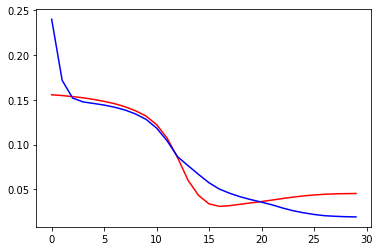

In [23]:
plt.plot(hist.history['val_loss'], 'r', hist.history['loss'], 'b')

###Building Classifier

In [24]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
encoder (Model)              (None, 15, 20, 15, 10)    5700      
_________________________________________________________________
decoder (Model)              (None, 120, 160, 120, 1)  8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.layers import Softmax

In [0]:
encoder_c = autoencoder.layers[1]

In [28]:
encoder_c.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 30, 10)    0   

###New Encoder, classifier to be

In [35]:
input_img = Input(shape= (120, 160, 120 , 1))
x = Conv3D(10, (3,3,3), activation='relu', padding='same')(input_img)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

encoded_shape = K.int_shape(x)

x = Flatten()(x)

x = Dense(32, activation='selu')(x)
x= Dense(16, activation='selu')(x)
new_encoded = Dense(2, activation='softmax')(x)


classifier=Model(input_img, new_encoded, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 40, 30, 10)    0

### Fitting data

In [36]:

classifier.layers

In [0]:
for layer_num in range(len(encoder_c.get_weights())):
  classifier.layers[layer_num].set_weights(encoder_c.layers[layer_num].get_weights())

In [0]:
#didn't freeze
classifier.compile(optimizer='adam', loss='binary_crossentropy')

In [39]:
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 40, 30, 10)    0

In [47]:
classifier_history= classifier.fit(x_train, y_train, batch_size=3, epochs=3, verbose=1, validation_data=(x_test, y_test))

Train on 9 samples, validate on 2 samples
Epoch 1/3
9/9 [==============================] - 0s 54ms/step - loss: 0.0024 - val_loss: 0.8251
Epoch 2/3
9/9 [==============================] - 0s 53ms/step - loss: 0.0042 - val_loss: 0.8269
Epoch 3/3
9/9 [==============================] - 0s 53ms/step - loss: 0.0243 - val_loss: 0.8248


In [48]:
classifier.predict(x_test)

array([[0.5629819 , 0.43701807],
       [0.56037897, 0.43962103]], dtype=float32)

In [49]:
classifier.evaluate(x_test, y_test, verbose=1)

2/2 [==============================] - 0s 18ms/step


0.8248112201690674